Using backend: tensorflow.compat.v1

2021-12-12 11:38:47.690385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term




heat_1d_boundary_sin_exact: Average time with 15 tries: 0.0003 seconds
finite_difference_crank_nicolson: Average time with 15 tries: 0.0099 seconds


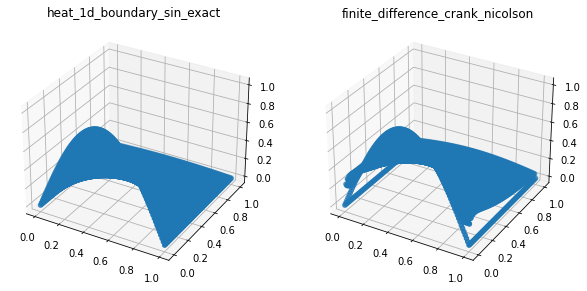

In [1]:
from dataclasses import dataclass

import numpy as np
import deepxde as dde

from project.gen_data import gen_data
from project.post_processing import Plotter
from project.timer import Timer

TIMER_REPEAT_TIMES = 15

# Problem parameters:
@dataclass
class PinnConstParam:
    a = 0.4 # Thermal diffusivity
    L = 1 # Length of the bar, Assum x starts at 0
    n = 1 # Frequency of the sinusoidal initial conditions
    t_end = 1 # Assume t_start  = 0
    test_x_dim = 100
    test_t_dim = 100
    analytical_function_name = "heat_1d_boundary_sin_exact"
    numerical_function_name = "finite_difference_crank_nicolson"
    X_test = None
    y_analytical = None
    y_numerical = None

@dataclass
class PinnTestParam:
    d_num_domain = 2540
    d_num_boundary = 80
    d_num_initial = 160
    nn_hidden_layer_size = 20
    nn_hidden_layer_num = 3

def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - const_params.a*dy_xx

def create_model(const_params: PinnConstParam, test_params: PinnTestParam):
    # Computational geometry:
    geom = dde.geometry.Interval(0, const_params.L)
    timedomain = dde.geometry.TimeDomain(0, const_params.t_end)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    # Initial and boundary conditions:
    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(
        geomtime, lambda x: np.sin(const_params.n*np.pi*x[:, 0:1]/const_params.L) , lambda _, on_initial: on_initial
        )

    geomtime_data = dde.data.TimePDE(
        geomtime, pde, [bc, ic],
        num_domain=test_params.d_num_domain,
        num_boundary=test_params.d_num_boundary,
        num_initial=test_params.d_num_initial,
        num_test=2540
    )

    nn_architecture = [2] + [test_params.nn_hidden_layer_size] * test_params.nn_hidden_layer_num + [1]
    net = dde.nn.FNN(
        nn_architecture,
        "tanh",
        "Glorot normal")

    model = dde.Model(geomtime_data, net)

    return geomtime_data, model

def train_model(model):
    # Build and train the model:
    model.compile("adam", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS")
    losshistory, train_state = model.train()

    return losshistory, train_state

def plot_train_data(geomtime_data):
    X_bc_train = geomtime_data.bc_points()
    print("train_bc_points shape", X_bc_train.shape)

    plotter = Plotter(1, 2)
    plotter.plot_2d(X_bc_train, "train_bc_points")

    # Train points are not used anymore because deepxde train_points(),
    # always generate random train points, but it is not what we are doing to
    # train the nn, in train_next_batch(). train_next_batch, isnt random!!
    # X_train_points = geomtime_data.train_points()
    # print("train_points shape", X_train_points.shape)
    # plotter.plot_2d(X_train_points, "train_domain_points")

    X_train_next_batch, _, _ = geomtime_data.train_next_batch()
    print("train_next_batch shape", X_train_next_batch.shape)
    plotter.plot_2d(X_train_next_batch, "train_next_batch")

def plot_analytical_and_numerical(plotter, const_params: PinnConstParam):
    # I. Analytical test solution
        plotter.plot_2d_y(
        const_params.X_test,
        const_params.y_analytical,
        const_params.analytical_function_name)

    # II. Numerical test solution
        plotter.plot_2d_y(
        const_params.X_test,
        const_params.y_numerical,
        const_params.numerical_function_name)

def predict_and_output_report(const_params: PinnConstParam, model, losshistory = None, train_state = None):
    plotter = Plotter(1, 3)

    plot_analytical_and_numerical(plotter, const_params)

    # III. Physics Informed Neural Network test solution``
    function_name = "PINN prediction"
    ti = Timer(TIMER_REPEAT_TIMES)
    y_pred = ti.time_average(lambda : model.predict(const_params.X_test))
    print(function_name + ": "+ ti.str_average())
    plotter.plot_2d_y(const_params.X_test, y_pred, function_name)

    # Train loss, and Test data from PDE test data
    if losshistory and train_state:
        dde.saveplot(losshistory, train_state, issave=False, isplot=True)
        print("IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^")

    f = model.predict(const_params.X_test, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(const_params.y_analytical, y_pred))
    # np.savetxt("test.dat", np.hstack((X_test, y_analytical, y_pred)))

# Generate constants throughout this app!!
const_params = PinnConstParam()

ti = Timer(TIMER_REPEAT_TIMES)
const_params.X_test, const_params.y_analytical = ti.time_average(lambda : gen_data(
    const_params.analytical_function_name,
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim,
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    }))
print(const_params.analytical_function_name + ": "+ ti.str_average())

X_test_num, const_params.y_numerical = ti.time_average(lambda : gen_data(
    const_params.numerical_function_name,
    {
        "x_range": (0, const_params.L),
        "t_range": (0, const_params.t_end),
        "x_dim": const_params.test_x_dim,
        "t_dim": const_params.test_t_dim,
        "a_coeff": const_params.a,
        "frequency": const_params.n,
    }))
print(const_params.numerical_function_name + ": "+ ti.str_average())

plotter = Plotter(1, 2)
plot_analytical_and_numerical(plotter, const_params)

# Test 1: Default parameters from DeepXde

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


train_bc_points shape (240, 2)
train_next_batch shape (3020, 2)


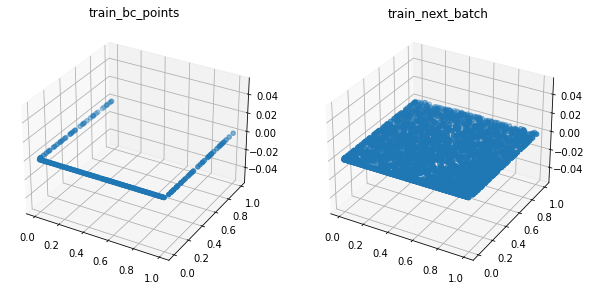

In [2]:
# Create model and plot training data
geomtime_data, model = create_model(const_params, PinnTestParam())
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.036841 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-12 11:38:49.910631: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-12 11:38:49.911324: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-12 11:38:49.951347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS ha

'compile' took 0.605210 s



2021-12-12 11:38:50.319314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-12 11:38:50.319347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2021-12-12 11:38:50.319353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2021-12-12 11:38:50.319601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 11:38:50.319965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 11:38:50.320300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.48e-02, 7.05e-02, 3.68e-01]    [7.31e-02, 7.05e-02, 3.68e-01]    []  


2021-12-12 11:38:50.553198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


1000      [9.81e-04, 1.08e-03, 2.74e-04]    [5.35e-04, 1.08e-03, 2.74e-04]    []  
2000      [2.76e-04, 6.02e-05, 3.71e-05]    [1.62e-04, 6.02e-05, 3.71e-05]    []  
3000      [6.96e-05, 7.41e-06, 7.56e-06]    [5.24e-05, 7.41e-06, 7.56e-06]    []  
4000      [2.75e-05, 3.72e-06, 3.17e-06]    [2.17e-05, 3.72e-06, 3.17e-06]    []  
5000      [4.72e-05, 1.72e-05, 3.84e-05]    [4.49e-05, 1.72e-05, 3.84e-05]    []  
6000      [8.07e-05, 1.82e-05, 5.59e-05]    [7.69e-05, 1.82e-05, 5.59e-05]    []  
7000      [1.48e-05, 2.24e-06, 1.32e-06]    [1.21e-05, 2.24e-06, 1.32e-06]    []  
8000      [1.41e-05, 2.11e-06, 1.21e-06]    [1.13e-05, 2.11e-06, 1.21e-06]    []  
9000      [1.85e-05, 1.19e-05, 2.02e-05]    [1.35e-05, 1.19e-05, 2.02e-05]    []  
10000     [1.27e-05, 2.31e-06, 1.47e-06]    [1.01e-05, 2.31e-06, 1.47e-06]    []  
11000     [9.82e-06, 1.07e-06, 7.20e-07]    [7.92e-06, 1.07e-06, 7.20e-07]    []  
12000     [4.79e-05, 2.14e-05, 6.18e-05]    [4.56e-05, 2.14e-05, 6.18e-05]    []  
1300

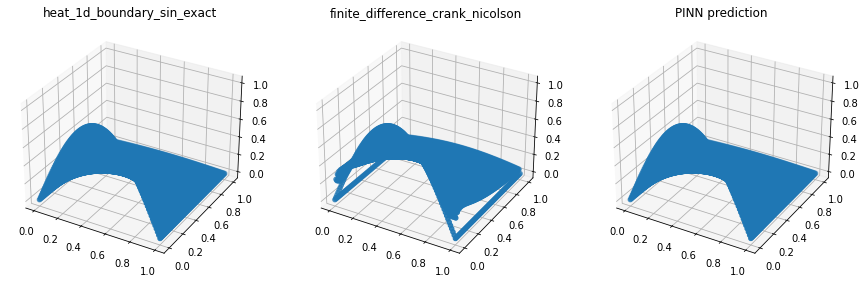

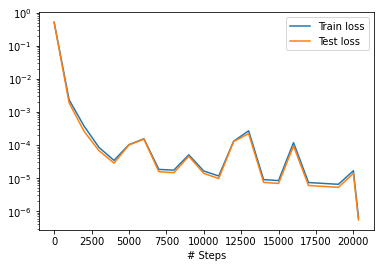

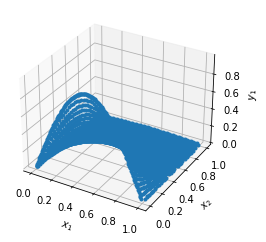

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0005197021
L2 relative error: 0.0007073522963217181


In [3]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 2: Reduce hidden layers and size to break solution

In [4]:
test_params = PinnTestParam()
test_params.nn_hidden_layer_num = 1
test_params.nn_hidden_layer_size = 5

geomtime_data, model = create_model(const_params, test_params)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


Compiling model...
Building feed-forward neural network...
'build' took 0.019682 s

'compile' took 0.134498 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-12 11:39:20.353523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 11:39:20.353924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER compute

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.59e-02, 4.85e-02, 2.96e-01]    [8.52e-02, 4.85e-02, 2.96e-01]    []  
1000      [1.89e-02, 3.81e-02, 7.62e-02]    [1.65e-02, 3.81e-02, 7.62e-02]    []  
2000      [1.83e-02, 3.59e-02, 6.53e-02]    [1.56e-02, 3.59e-02, 6.53e-02]    []  
3000      [1.64e-02, 3.03e-02, 5.47e-02]    [1.38e-02, 3.03e-02, 5.47e-02]    []  
4000      [1.66e-02, 2.05e-02, 4.31e-02]    [1.41e-02, 2.05e-02, 4.31e-02]    []  
5000      [1.32e-02, 5.96e-03, 1.73e-02]    [9.88e-03, 5.96e-03, 1.73e-02]    []  
6000      [9.08e-03, 3.91e-03, 1.10e-02]    [7.13e-03, 3.91e-03, 1.10e-02]    []  
7000      [8.06e-03, 3.90e-03, 9.90e-03]    [6.32e-03, 3.90e-03, 9.90e-03]    []  
8000      [7.13e-03, 4.08e-03, 9.21e-03]    [5.59e-03, 4.08e-03, 9.21e-03]    []  
9000      [6.30e-03, 4.34e-03, 8.70e-03]    [4.93e-03, 4.34e-03, 8.70e-03]    []  
10000     [5.55e-03, 4.62e-03, 8.29

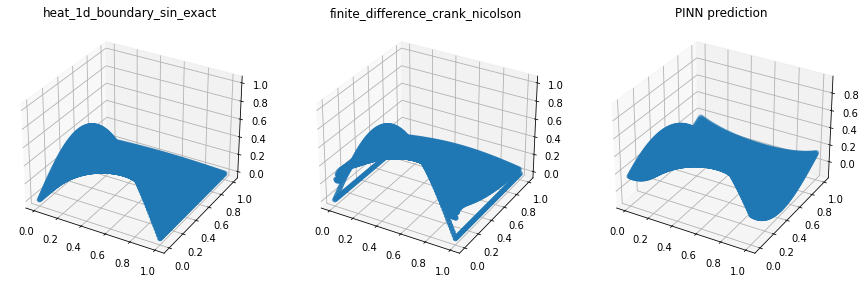

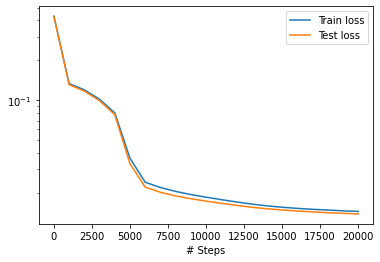

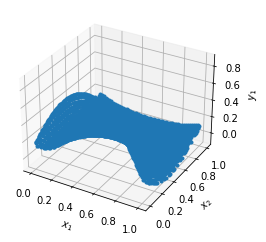

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.041112874
L2 relative error: 0.20266969999990245


In [5]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 3: Reduce boundary points to break solution

train_bc_points shape (6, 2)
train_next_batch shape (2552, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+5=5. 
  warnings.warn("The balance properties of Sobol' points require "


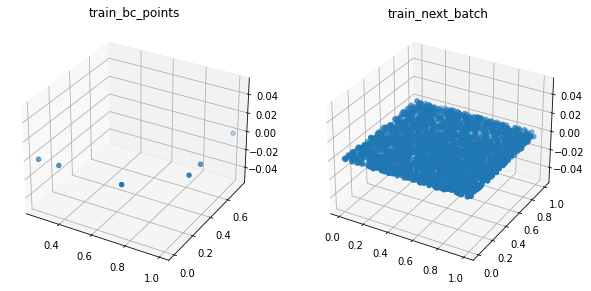

In [6]:
test_params = PinnTestParam()
test_params.d_num_boundary = 3
test_params.d_num_initial = 3

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.032101 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-12 11:39:38.616654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 11:39:38.617074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER compute

'compile' took 0.225827 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.59e-03, 1.72e-01, 3.29e-01]    [8.52e-03, 1.72e-01, 3.29e-01]    []  
1000      [1.75e-03, 2.44e-03, 2.99e-03]    [1.42e-03, 2.44e-03, 2.99e-03]    []  
2000      [4.06e-04, 4.70e-05, 2.52e-04]    [2.84e-04, 4.70e-05, 2.52e-04]    []  
3000      [1.19e-04, 1.31e-05, 1.72e-05]    [9.23e-05, 1.31e-05, 1.72e-05]    []  
4000      [6.11e-05, 3.20e-06, 2.22e-06]    [4.87e-05, 3.20e-06, 2.22e-06]    []  
5000      [5.99e-05, 1.60e-05, 6.37e-06]    [4.52e-05, 1.60e-05, 6.37e-06]    []  
6000      [3.84e-05, 1.56e-06, 7.76e-07]    [3.01e-05, 1.56e-06, 7.76e-07]    []  
7000      [3.26e-05, 1.43e-06, 4.84e-07]    [2.57e-05, 1.43e-06, 4.84e-07]    []  
8000      [2.82e-05, 1.23e-06, 3.24e-07]    [2.21e-05, 1.23e-06, 3.24e-07]    []  
9000      [2.45e-05, 1.12e-06, 2.65e-07]    [1.92e-05, 1.12e-06, 2.65e-07]    []  
10000   

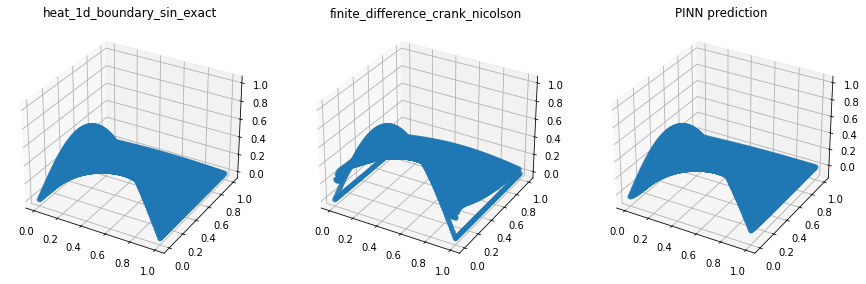

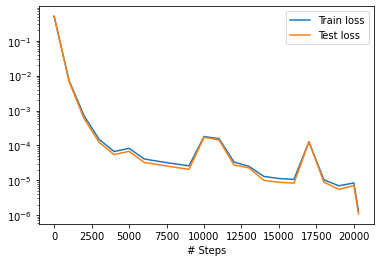

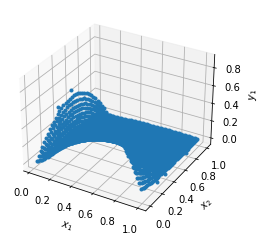

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.00087733194
L2 relative error: 0.11829282221431209


In [7]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)

# Test 4: Reduce domain to break solution

train_bc_points shape (240, 2)
train_next_batch shape (530, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


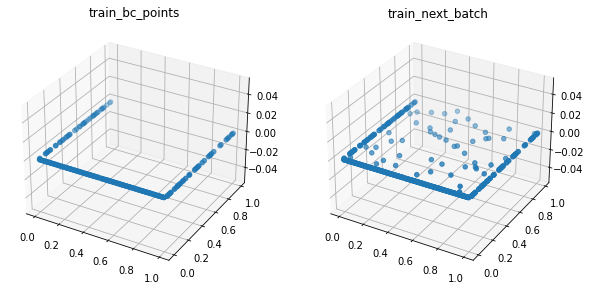

In [8]:
test_params = PinnTestParam()
test_params.d_num_domain = 50

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

Compiling model...
Building feed-forward neural network...
'build' took 0.031954 s



/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-12-12 11:40:10.283220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 11:40:10.283641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER compute

'compile' took 0.238066 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.27e-01, 1.22e-01, 2.36e-01]    [3.79e-01, 1.22e-01, 2.36e-01]    []  
1000      [1.55e-03, 1.13e-03, 6.76e-04]    [7.99e-03, 1.13e-03, 6.76e-04]    []  
2000      [3.04e-04, 1.05e-04, 4.00e-05]    [9.18e-04, 1.05e-04, 4.00e-05]    []  
3000      [1.09e-04, 3.64e-05, 6.81e-06]    [4.58e-04, 3.64e-05, 6.81e-06]    []  
4000      [5.06e-05, 2.11e-05, 2.87e-06]    [2.39e-04, 2.11e-05, 2.87e-06]    []  
5000      [3.32e-05, 1.39e-05, 1.75e-06]    [1.54e-04, 1.39e-05, 1.75e-06]    []  
6000      [2.52e-05, 9.63e-06, 1.10e-06]    [1.16e-04, 9.63e-06, 1.10e-06]    []  
7000      [2.27e-05, 7.52e-06, 7.21e-07]    [1.04e-04, 7.52e-06, 7.21e-07]    []  
8000      [1.63e-05, 5.28e-06, 4.90e-07]    [8.79e-05, 5.28e-06, 4.90e-07]    []  
9000      [1.34e-05, 4.01e-06, 3.25e-07]    [8.37e-05, 4.01e-06, 3.25e-07]    []  
10000   

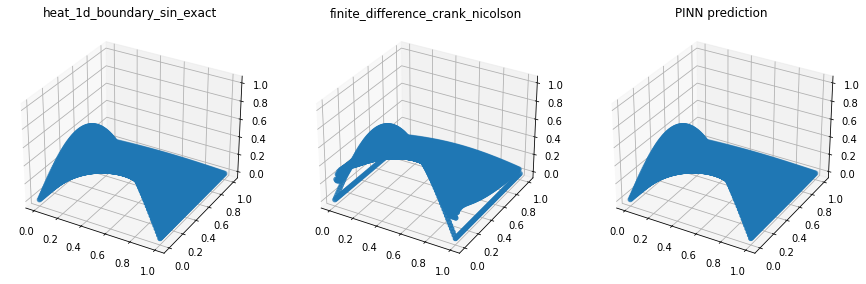

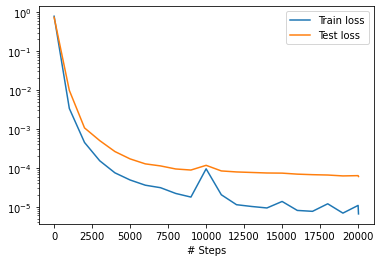

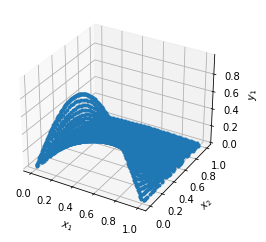

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.0050388207
L2 relative error: 0.002100878425391989


In [9]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)


# Test 5: Reduce train data (domain and bc) to break solution

train_bc_points shape (20, 2)
train_next_batch shape (90, 2)


/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+52=52. 
  warnings.warn("The balance properties of Sobol' points require "
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "


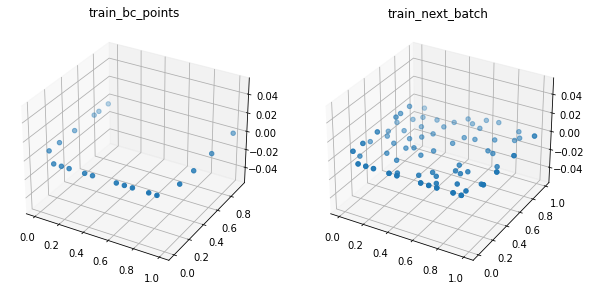

In [10]:
test_params = PinnTestParam()
test_params.d_num_domain = 50
test_params.d_num_boundary = 10
test_params.d_num_initial = 10

geomtime_data, model = create_model(const_params, test_params)
plot_train_data(geomtime_data)

/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/radian/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Compiling model...
Building feed-forward neural network...
'build' took 0.031589 s



2021-12-12 11:40:40.167734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-12 11:40:40.168122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.77GHz coreCount: 40 deviceMemorySize: 7.78GiB deviceMemoryBandwidth: 417.29GiB/s
2021-12-12 11:40:40.168154: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-12 11:40:40.168179: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-12 11:40:40.168189: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2021-12-12 11:40:40.168198: I tensorflow/stream_ex

'compile' took 0.244610 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [8.77e-01, 4.88e-01, 8.77e-01]    [8.14e-01, 4.88e-01, 8.77e-01]    []  
1000      [3.22e-03, 5.07e-03, 9.48e-03]    [2.93e-03, 5.07e-03, 9.48e-03]    []  
2000      [1.32e-03, 9.22e-04, 4.25e-04]    [4.48e-03, 9.22e-04, 4.25e-04]    []  
3000      [4.63e-04, 2.09e-04, 1.30e-04]    [4.43e-03, 2.09e-04, 1.30e-04]    []  
4000      [1.97e-04, 5.10e-05, 7.53e-05]    [4.01e-03, 5.10e-05, 7.53e-05]    []  
5000      [1.06e-04, 2.14e-05, 4.70e-05]    [3.04e-03, 2.14e-05, 4.70e-05]    []  
6000      [6.93e-05, 1.27e-05, 3.01e-05]    [2.20e-03, 1.27e-05, 3.01e-05]    []  
7000      [5.90e-05, 9.39e-06, 1.91e-05]    [1.57e-03, 9.39e-06, 1.91e-05]    []  
8000      [3.37e-05, 5.37e-06, 1.20e-05]    [1.22e-03, 5.37e-06, 1.20e-05]    []  
9000      [3.36e-05, 1.17e-05, 3.86e-05]    [1.02e-03, 1.17e-05, 3.86e-05]    []  
10000   

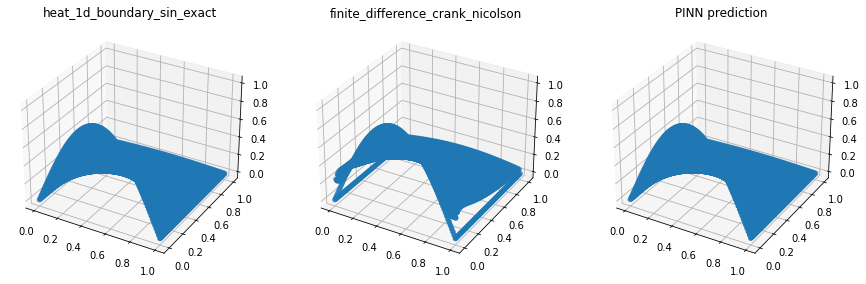

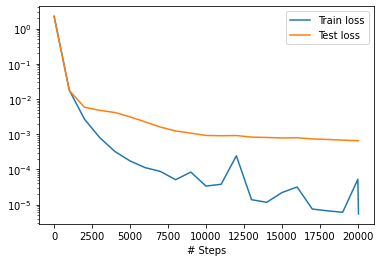

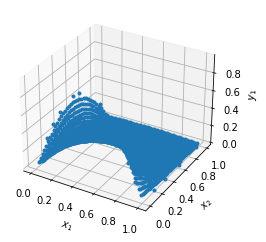

IGNORE ^^^ PDE test data SOLUTION PLOT!!! ^^^
Mean residual: 0.006133206
L2 relative error: 0.0028009020152112815


In [11]:
# Train model and output results
losshistory, train_state = train_model(model)
predict_and_output_report(const_params, model, losshistory, train_state)
